**Sentiment analysis** is used to determine whether a given text contains negative, positive, or neutral emotions. It's a form of text analytics that uses natural language processing (NLP) and machine learning.

**LSTM** Utilizes “forget” and “learn” gates that feed to “remember” and “use” gates, where remembering is for further storage for the next input, and using is for generating the current output

**Subwords** are another approach, where individual words are broken up into the more commonly appearing pieces of themselves. This helps avoid marking very rare words as OOV when you use only the most common words in a corpus.

**Dataset Source** : https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set

**Goal** : Determine whether the reviews given by customers are positive or negative, which is learned from previous reviews. 

#### 1. Import Library

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 2. Get Dataset

In [17]:
path = tf.keras.utils.get_file('reviews.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print(path)

/root/.keras/datasets/reviews.csv


In [18]:
# get csv file
dataset = pd.read_csv(path)
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


#### 3. Preprocessing

In [19]:
# Extract sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

#Check
for x in range(2):
  print(sentences[x])
  print(labels[x])

So there is no way for me to plug it in here in the US unless I go by a converter.
0
Good case Excellent value.
1


#### 4. Create Subword and Tokenizer

In [20]:
# Create subword dataset
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# Check
print('Vocal size is', tokenizer.vocab_size)

# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

Vocal size is 999
I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [22]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [24]:
# Replace sentence data with encoded subwords
# Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

# check
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


#### 5. Split Training and Testing Dataset
Divide the dataset into 2 parts, Training dataset and Testing dataset

In [25]:
max_length = 50
trunc_type = 'post'
padding_type = 'post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Separate sentenses and labels into training and tets dataset (80%-20%)
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Transform labels into numpy array, this will be used for the network later on build model part
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


#### 6. Build The Model

In [27]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 32)           4224      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-traina

#### 7. Train The Model

In [28]:
num_epochs = 30

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, 
                    training_labels_final, 
                    epochs=num_epochs, 
                    validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 13s 98ms/step - loss: 0.6924 - accuracy: 0.5210 - val_loss: 0.6972 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 3s 63ms/step - loss: 0.6322 - accuracy: 0.6466 - val_loss: 0.5299 - val_accuracy: 0.7519
Epoch 3/30
50/50 [==============================] - 3s 63ms/step - loss: 0.4128 - accuracy: 0.8180 - val_loss: 0.5541 - val_accuracy: 0.7368
Epoch 4/30
50/50 [==============================] - 3s 63ms/step - loss: 0.3002 - accuracy: 0.8851 - val_loss: 0.6061 - val_accuracy: 0.7368
Epoch 5/30
50/50 [==============================] - 3s 63ms/step - loss: 0.2349 - accuracy: 0.9184 - val_loss: 0.5823 - val_accuracy: 0.7694
Epoch 6/30
50/50 [==============================] - 3s 63ms/step - loss: 0.2145 - accuracy: 0.9266 - val_loss: 0.6600 - val_accuracy: 0.7644
Epoch 7/30
50/50 [==============================] - 3s 64ms/step - loss: 0.1598 - accuracy: 0.9529 - val_loss: 0.7045 - val_accuracy: 0.7669
Epoch 8/30
5

#### 7. Visualize Training Graph

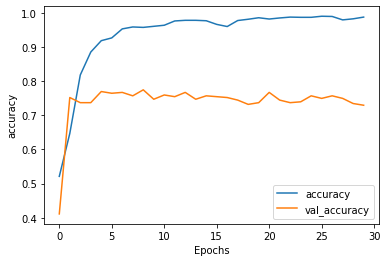

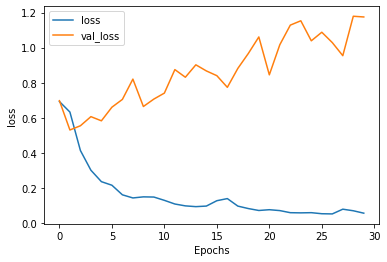

In [29]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#### 8. Predict Some New Reviews

In [30]:
# New Reviews   
new_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review
# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []
  
  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [32]:
predict_review(model, new_reviews)

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99871755]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01929688]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.96945584]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.01834053]


[  1 109 228 540 237 635 2